# Finetune google/muril-base-cased for Domain Classification

This notebook finetunes the **MuRIL** (Multilingual Representations for Indian Languages) model on a Maithili text dataset for **multi-class domain classification** (Agriculture, Finance, General, Health).

**Workflow:**
1. Install & import libraries
2. Load and explore the dataset
3. Encode labels, split data (train/val/test)
4. Tokenize with MuRIL tokenizer
5. Train the model with validation tracking
6. Evaluate with comprehensive metrics
7. Save the finetuned model
8. Load & run inference with probability-based thresholding

## 1. Install and Import Required Libraries

In [1]:
!pip install transformers datasets accelerate scikit-learn seaborn matplotlib pandas numpy torch --quiet

In [2]:
import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Load and Explore the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
dataset_path = "/content/drive/MyDrive/office_work/datasets/with_health.csv"
df = pd.read_csv(dataset_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn dtypes:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDomain distribution:\n{df['domain'].value_counts()}")
print(f"\nSample rows:")
df.head(10)

Dataset shape: (900, 2)

Column dtypes:
text      object
domain    object
dtype: object

Missing values:
text      0
domain    0
dtype: int64

Domain distribution:
domain
Health         225
General        225
Finance        225
Agriculture    225
Name: count, dtype: int64

Sample rows:


,text,domain
0,ओना मूड स्टेप्लाइजर के दवाई बिना डॉक्टर के लिख...,Health
1,"देखियौ, जखन अपन सँगीत या गीत नई हुए तखन पिरोडी...",General
2,कागज पर छापल धनक उपयोग अंतर्निहित वस्तु के अदल...,Finance
3,भार ओर माप की होय छै ?,Agriculture
4,टूटल हाड़ के जोड़बाक लेल प्रयुक्त धातुक छऽर के ब...,Health
5,कंदर्पीघाट केर यद्धक पछाति शोणितसँ सनाएल चौहत्...,General
6,हुनकर बनायल चित्रक रिफ्लेक्शन से बुझा रहल अछी ...,Finance
7,इंसुलिन एकटा पेप्टाइड हार्मोन छै जे मनुष्य में...,Health
8,स्त्रीक जननांगमे सबसँ पहिने बाल होइत अछि जकरा ...,Health
9,जहाज क॑ मानव निर्मित शत्रुतापूर्ण वातावरण मे स...,Health


Cleaned dataset shape: (900, 2)

Domain distribution after cleaning:
domain
Health         225
General        225
Finance        225
Agriculture    225
Name: count, dtype: int64


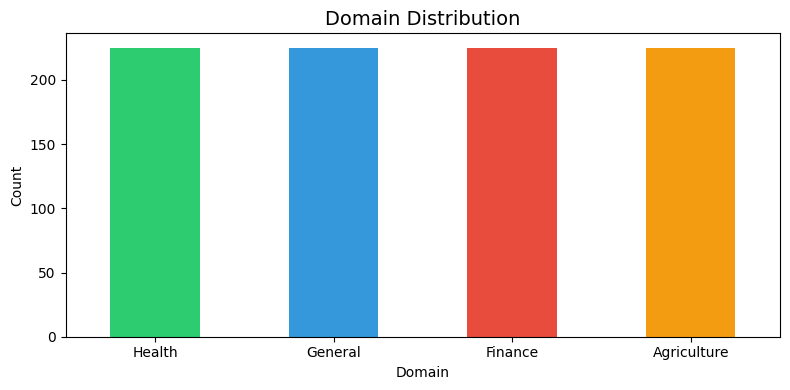

In [5]:
# Drop rows with missing text or domain
df = df.dropna(subset=["text", "domain"]).reset_index(drop=True)

# Keep only valid domain labels
valid_domains = ["Agriculture", "Finance", "General", "Health"]
df = df[df["domain"].isin(valid_domains)].reset_index(drop=True)

print(f"Cleaned dataset shape: {df.shape}")
print(f"\nDomain distribution after cleaning:\n{df['domain'].value_counts()}")

# Plot domain distribution
fig, ax = plt.subplots(figsize=(8, 4))
df["domain"].value_counts().plot(kind="bar", ax=ax, color=["#2ecc71", "#3498db", "#e74c3c", "#f39c12"])
ax.set_title("Domain Distribution", fontsize=14)
ax.set_xlabel("Domain")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Encode Domain Labels

In [6]:
# Encode domain labels to integers
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["domain"])

# Create mappings
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in id2label.items()}
num_labels = len(id2label)

print(f"Number of classes: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")
print(f"\nLabel distribution:")
print(df[["domain", "label"]].drop_duplicates().sort_values("label"))

Number of classes: 4
id2label: {0: 'Agriculture', 1: 'Finance', 2: 'General', 3: 'Health'}
label2id: {'Agriculture': 0, 'Finance': 1, 'General': 2, 'Health': 3}

Label distribution:
        domain  label
3  Agriculture      0
2      Finance      1
1      General      2
0       Health      3


## 4. Train-Validation-Test Split (70/15/15)

In [7]:
# Split: 70% train, 15% validation, 15% test (stratified)
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df["label"])

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(f"\nTrain domain distribution:\n{train_df['domain'].value_counts()}")
print(f"\nVal domain distribution:\n{val_df['domain'].value_counts()}")
print(f"\nTest domain distribution:\n{test_df['domain'].value_counts()}")

Train size: 630
Validation size: 135
Test size: 135

Train domain distribution:
domain
Finance        158
Health         158
Agriculture    157
General        157
Name: count, dtype: int64

Val domain distribution:
domain
Agriculture    34
General        34
Health         34
Finance        33
Name: count, dtype: int64

Test domain distribution:
domain
General        34
Finance        34
Agriculture    34
Health         33
Name: count, dtype: int64


## 5. Tokenize the Dataset with MuRIL Tokenizer

In [8]:
MODEL_NAME = "google/muril-base-cased"
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(texts, labels, tokenizer, max_length=MAX_LENGTH):
    """Tokenize texts and return encodings with labels."""
    encodings = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    encodings["labels"] = torch.tensor(labels.tolist(), dtype=torch.long)
    return encodings

train_encodings = tokenize_data(train_df["text"], train_df["label"], tokenizer)
val_encodings = tokenize_data(val_df["text"], val_df["label"], tokenizer)
test_encodings = tokenize_data(test_df["text"], test_df["label"], tokenizer)

print(f"Train encodings keys: {list(train_encodings.keys())}")
print(f"Train input_ids shape: {train_encodings['input_ids'].shape}")
print(f"Val input_ids shape: {val_encodings['input_ids'].shape}")
print(f"Test input_ids shape: {test_encodings['input_ids'].shape}")

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

Train encodings keys: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
Train input_ids shape: torch.Size([630, 256])
Val input_ids shape: torch.Size([135, 256])
Test input_ids shape: torch.Size([135, 256])


## 6. Create PyTorch Datasets and DataLoaders

In [9]:
class DomainDataset(Dataset):
    """Custom PyTorch Dataset for domain classification."""
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.encodings["labels"][idx],
        }

BATCH_SIZE = 16

train_dataset = DomainDataset(train_encodings)
val_dataset = DomainDataset(val_encodings)
test_dataset = DomainDataset(test_encodings)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 40
Val batches: 9
Test batches: 9


## 7. Load Pretrained MuRIL Model for Sequence Classification

In [10]:
# Load MuRIL model with classification head
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)

print(f"Model loaded: {MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google/muril-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expe

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Model loaded: google/muril-base-cased
Number of parameters: 237,559,300
Number of trainable parameters: 237,559,300


## 8. Setup Training Configuration (Optimizer, Scheduler)

In [11]:
# Hyperparameters
LEARNING_RATE = 2e-5
NUM_EPOCHS = 25
WARMUP_RATIO = 0.1

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Total training steps
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

# Learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Learning rate: 2e-05
Epochs: 25
Total training steps: 1000
Warmup steps: 100


## 9. Training Loop with Validation

In [12]:
# Storage for metrics across epochs
history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "val_f1": [],
}

best_val_f1 = 0.0

for epoch in range(NUM_EPOCHS):
    # ---- Training Phase ----
    model.train()
    total_train_loss = 0
    train_steps = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        train_steps += 1

    avg_train_loss = total_train_loss / train_steps

    # ---- Validation Phase ----
    model.eval()
    total_val_loss = 0
    val_steps = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            val_steps += 1

            preds = torch.argmax(outputs.logits, dim=-1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / val_steps
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_f1 = f1_score(all_val_labels, all_val_preds, average="weighted")

    # Store metrics
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_accuracy)
    history["val_f1"].append(val_f1)

    # Track best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_accuracy:.4f} | "
        f"Val F1: {val_f1:.4f}"
    )

print(f"\nBest Val F1: {best_val_f1:.4f} at Epoch {best_epoch}")

Epoch 1/25 | Train Loss: 1.3863 | Val Loss: 1.3862 | Val Acc: 0.2519 | Val F1: 0.1013
Epoch 2/25 | Train Loss: 1.3852 | Val Loss: 1.3798 | Val Acc: 0.6000 | Val F1: 0.6004
Epoch 3/25 | Train Loss: 1.3412 | Val Loss: 1.2884 | Val Acc: 0.7852 | Val F1: 0.7787
Epoch 4/25 | Train Loss: 1.2332 | Val Loss: 1.1880 | Val Acc: 0.7852 | Val F1: 0.7879
Epoch 5/25 | Train Loss: 1.1291 | Val Loss: 1.1010 | Val Acc: 0.8148 | Val F1: 0.8160
Epoch 6/25 | Train Loss: 1.0203 | Val Loss: 1.0027 | Val Acc: 0.8370 | Val F1: 0.8361
Epoch 7/25 | Train Loss: 0.9034 | Val Loss: 0.9232 | Val Acc: 0.8148 | Val F1: 0.8110
Epoch 8/25 | Train Loss: 0.7887 | Val Loss: 0.8556 | Val Acc: 0.8148 | Val F1: 0.8138
Epoch 9/25 | Train Loss: 0.6975 | Val Loss: 0.7879 | Val Acc: 0.8222 | Val F1: 0.8234
Epoch 10/25 | Train Loss: 0.6058 | Val Loss: 0.7429 | Val Acc: 0.8148 | Val F1: 0.8151
Epoch 11/25 | Train Loss: 0.5258 | Val Loss: 0.6746 | Val Acc: 0.8370 | Val F1: 0.8348
Epoch 12/25 | Train Loss: 0.4554 | Val Loss: 0.7013 

## 10. Plot Training and Validation Loss / Accuracy Curves

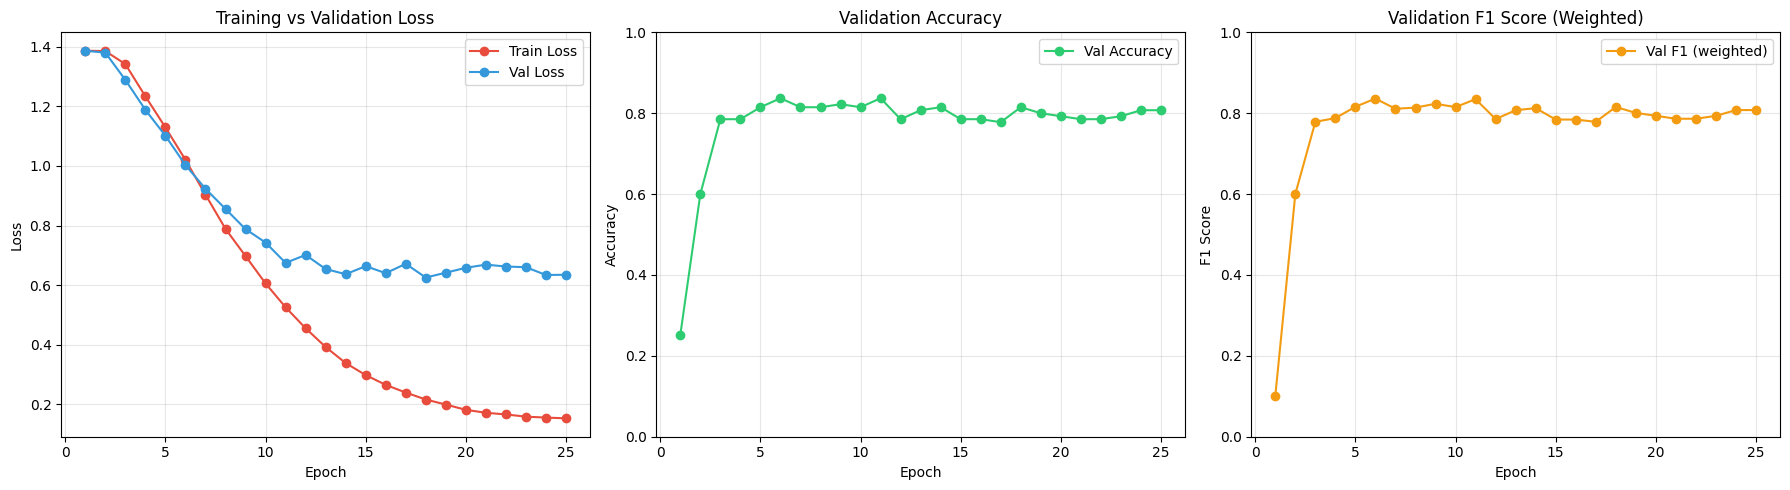

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
epochs_range = range(1, NUM_EPOCHS + 1)

# Plot 1: Train vs Val Loss
axes[0].plot(epochs_range, history["train_loss"], "o-", label="Train Loss", color="#e74c3c")
axes[0].plot(epochs_range, history["val_loss"], "o-", label="Val Loss", color="#3498db")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training vs Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
axes[1].plot(epochs_range, history["val_accuracy"], "o-", label="Val Accuracy", color="#2ecc71")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# Plot 3: Validation F1 Score
axes[2].plot(epochs_range, history["val_f1"], "o-", label="Val F1 (weighted)", color="#f39c12")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("Validation F1 Score (Weighted)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 11. Evaluate on Test Set — Classification Report, Confusion Matrix, F1, Precision, Recall

In [18]:
# Evaluate on test set
model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Convert to numpy
all_test_preds = np.array(all_test_preds)
all_test_labels = np.array(all_test_labels)

# Overall metrics
test_accuracy = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(all_test_labels, all_test_preds, average="weighted")
test_recall = recall_score(all_test_labels, all_test_preds, average="weighted")
test_f1 = f1_score(all_test_labels, all_test_preds, average="weighted")

print("=" * 60)
print("TEST SET EVALUATION RESULTS")
print("=" * 60)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f} (weighted)")
print(f"Recall:    {test_recall:.4f} (weighted)")
print(f"F1 Score:  {test_f1:.4f} (weighted)")
print("=" * 60)

# Detailed classification report
target_names = [id2label[i] for i in range(num_labels)]
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
print("Confusion Matrix:")
print(cm)

TEST SET EVALUATION RESULTS
Accuracy:  0.8889
Precision: 0.8890 (weighted)
Recall:    0.8889 (weighted)
F1 Score:  0.8878 (weighted)

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.87      0.97      0.92        34
     Finance       0.94      0.94      0.94        34
     General       0.91      0.85      0.88        34
      Health       0.84      0.79      0.81        33

    accuracy                           0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.89      0.89      0.89       135

Confusion Matrix:
[[33  0  0  1]
 [ 1 32  0  1]
 [ 2  0 29  3]
 [ 2  2  3 26]]


## 12. Plot Confusion Matrix Heatmap

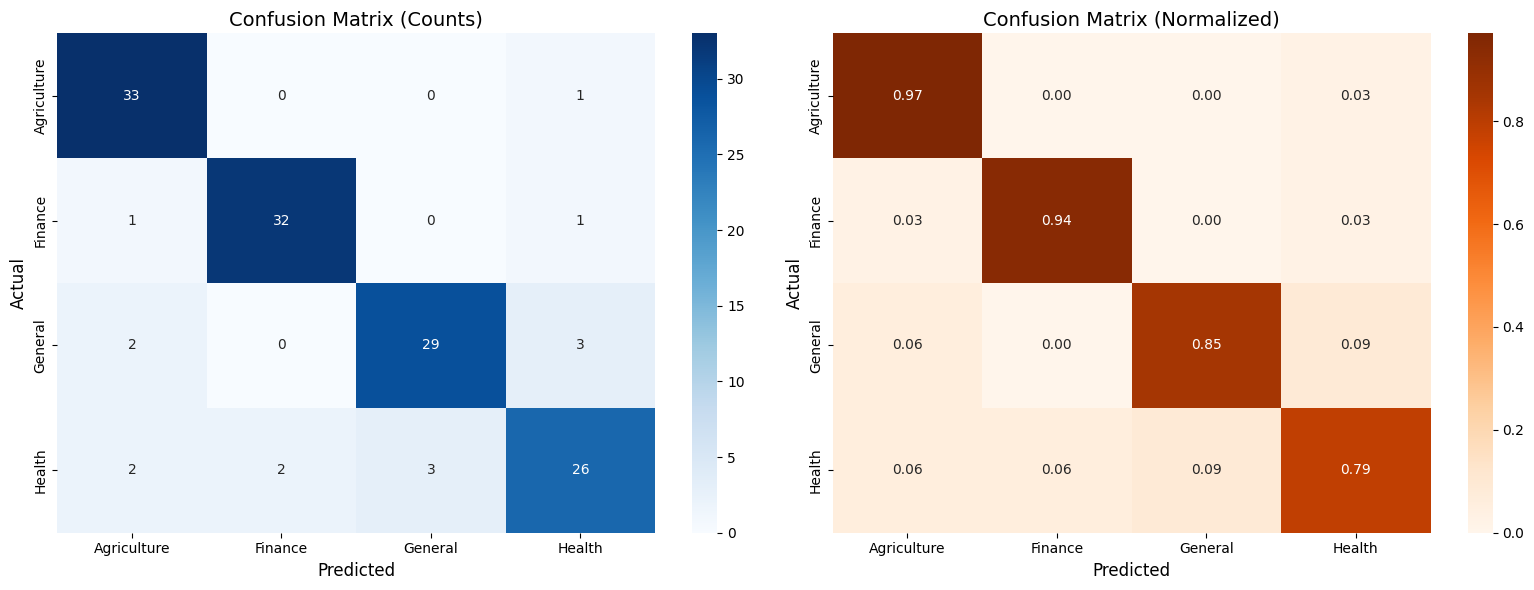

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion matrix with counts
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
    ax=axes[0],
)
axes[0].set_xlabel("Predicted", fontsize=12)
axes[0].set_ylabel("Actual", fontsize=12)
axes[0].set_title("Confusion Matrix (Counts)", fontsize=14)

# Plot 2: Normalized confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    xticklabels=target_names,
    yticklabels=target_names,
    ax=axes[1],
)
axes[1].set_xlabel("Predicted", fontsize=12)
axes[1].set_ylabel("Actual", fontsize=12)
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=14)

plt.tight_layout()
plt.show()

## 13. Save the Finetuned Model and Tokenizer

In [20]:
SAVE_DIR = "/content/drive/MyDrive/office_work/saved_models/with_health_more"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save model and tokenizer
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

# Save label mappings
label_mappings = {
    "id2label": id2label,
    "label2id": label2id,
    "classes": list(label_encoder.classes_),
}
with open(os.path.join(SAVE_DIR, "label_mappings.json"), "w", encoding="utf-8") as f:
    json.dump(label_mappings, f, ensure_ascii=False, indent=2)

# Save training history
with open(os.path.join(SAVE_DIR, "training_history.json"), "w") as f:
    json.dump(history, f, indent=2)

print(f"Model saved to: {SAVE_DIR}")
print(f"Files saved:")
for fname in os.listdir(SAVE_DIR):
    fsize = os.path.getsize(os.path.join(SAVE_DIR, fname))
    print(f"  {fname} ({fsize / 1024:.1f} KB)")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved to: /content/drive/MyDrive/office_work/saved_models/with_health_more
Files saved:
  config.json (0.9 KB)
  model.safetensors (927989.0 KB)
  tokenizer_config.json (0.3 KB)
  tokenizer.json (6257.7 KB)
  label_mappings.json (0.3 KB)
  training_history.json (2.4 KB)


## 14. Load the Saved Model for Inference

In [22]:
LOAD_DIR = "/content/drive/MyDrive/office_work/saved_models/with_health_more"

# Load model, tokenizer, and label mappings
loaded_model = AutoModelForSequenceClassification.from_pretrained(LOAD_DIR)
loaded_tokenizer = AutoTokenizer.from_pretrained(LOAD_DIR)

with open(os.path.join(LOAD_DIR, "label_mappings.json"), "r", encoding="utf-8") as f:
    loaded_label_mappings = json.load(f)

loaded_id2label = {int(k): v for k, v in loaded_label_mappings["id2label"].items()}
loaded_label2id = loaded_label_mappings["label2id"]

# Move model to device and set eval mode
loaded_model.to(device)
loaded_model.eval()

print(f"Model loaded from: {LOAD_DIR}")
print(f"Labels: {loaded_id2label}")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded from: /content/drive/MyDrive/office_work/saved_models/with_health_more
Labels: {0: 'Agriculture', 1: 'Finance', 2: 'General', 3: 'Health'}


## 15. Inference Function with Domain Probabilities and Threshold-Based General Category

If the highest predicted probability is **below the threshold** (default: 0.5), the text is classified as **"General"** instead of the predicted domain.

In [21]:
def predict_domain(text, model, tokenizer, id2label, threshold=0.5, max_length=256):
    """
    Predict domain for a given text with probability-based thresholding.

    Args:
        text: Input text string
        model: Finetuned model
        tokenizer: Tokenizer
        id2label: Mapping from label id to label name
        threshold: Minimum probability for confident prediction (default: 0.5)
        max_length: Maximum token length

    Returns:
        dict with predicted_domain, probabilities, and confidence info
    """
    # Tokenize
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    ).to(device)

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1).squeeze().cpu().numpy()

    # Get all domain probabilities
    domain_probs = {id2label[i]: float(probabilities[i]) for i in range(len(id2label))}

    # Get top prediction
    pred_id = np.argmax(probabilities)
    pred_label = id2label[pred_id]
    pred_prob = float(probabilities[pred_id])

    # Apply threshold: if max probability < threshold, assign to "General"
    if pred_prob < threshold:
        final_domain = "General"
        thresholded = True
    else:
        final_domain = pred_label
        thresholded = False

    return {
        "text": text[:80] + "..." if len(text) > 80 else text,
        "predicted_domain": pred_label,
        "final_domain": final_domain,
        "confidence": pred_prob,
        "thresholded": thresholded,
        "probabilities": domain_probs,
    }


def print_prediction(result):
    """Pretty print a prediction result."""
    print(f"\n{'='*70}")
    print(f"Text: {result['text']}")
    print(f"{'─'*70}")
    print(f"  Domain Probabilities:")
    for domain, prob in sorted(result["probabilities"].items(), key=lambda x: -x[1]):
        bar = "█" * int(prob * 40)
        print(f"    {domain:<15} {prob:.4f}  {bar}")
    print(f"{'─'*70}")
    print(f"  Model Prediction : {result['predicted_domain']} ({result['confidence']:.4f})")
    if result["thresholded"]:
        print(f"  ⚠ Confidence below threshold → Final Domain: {result['final_domain']}")
    else:
        print(f"  ✓ Final Domain   : {result['final_domain']}")
    print(f"{'='*70}")

## 16. Run Inference on Sample Texts and Display Results

In [23]:
# Sample texts for inference (from different domains)
sample_texts = [
    # Agriculture-related
    "धान के खेती मे पानी के प्रबंधन बहुत जरूरी छै",
    # Health-related
    "डॉक्टर कहलनि कि दवाई समय पर खाउ आ आराम करू",
    # Finance-related
    "बैंक मे खाता खोलबा लेल आधार कार्ड आ पैन कार्ड चाही",
    # General/ambiguous
    "आइ मौसम बहुत नीक अछि",
    # Agriculture
    "गहूम के फसल मे सिंचाई के उचित समय जानब जरूरी छै",
    # Health
    "मधुमेह के रोगी कें नियमित रूप सं जांच करएबाक चाही",
]

THRESHOLD = 0.5
print(f"Inference Threshold: {THRESHOLD}")
print(f"(If max probability < {THRESHOLD}, text is classified as 'General')\n")

results = []
for text in sample_texts:
    result = predict_domain(text, loaded_model, loaded_tokenizer, loaded_id2label, threshold=THRESHOLD)
    print_prediction(result)
    results.append(result)

Inference Threshold: 0.5
(If max probability < 0.5, text is classified as 'General')


Text: धान के खेती मे पानी के प्रबंधन बहुत जरूरी छै
──────────────────────────────────────────────────────────────────────
  Domain Probabilities:
    Agriculture     0.8877  ███████████████████████████████████
    Finance         0.0516  ██
    Health          0.0317  █
    General         0.0289  █
──────────────────────────────────────────────────────────────────────
  Model Prediction : Agriculture (0.8877)
  ✓ Final Domain   : Agriculture

Text: डॉक्टर कहलनि कि दवाई समय पर खाउ आ आराम करू
──────────────────────────────────────────────────────────────────────
  Domain Probabilities:
    Health          0.8537  ██████████████████████████████████
    General         0.0729  ██
    Finance         0.0368  █
    Agriculture     0.0366  █
──────────────────────────────────────────────────────────────────────
  Model Prediction : Health (0.8537)
  ✓ Final Domain   : Health

Text: बैंक मे खाता खोलबा लेल आ

In [ ]:
# Sample texts for inference (from different domains)
sample_texts = [
    # Agriculture-related
    "धान के खेती मे पानी के प्रबंधन बहुत जरूरी छै",
    # Health-related
    "डॉक्टर कहलनि कि दवाई समय पर खाउ आ आराम करू",
    # Finance-related
    "बैंक मे खाता खोलबा लेल आधार कार्ड आ पैन कार्ड चाही",
    # General/ambiguous
    "आइ मौसम बहुत नीक अछि",
    # Agriculture
    "गहूम के फसल मे सिंचाई के उचित समय जानब जरूरी छै",
    # Health
    "मधुमेह के रोगी कें नियमित रूप सं जांच करएबाक चाही",
]

THRESHOLD = 0.5
print(f"Inference Threshold: {THRESHOLD}")
print(f"(If max probability < {THRESHOLD}, text is classified as 'General')\n")

results = []
for text in sample_texts:
    result = predict_domain(text, loaded_model, loaded_tokenizer, loaded_id2label, threshold=THRESHOLD)
    print_prediction(result)
    results.append(result)

Inference Threshold: 0.5
(If max probability < 0.5, text is classified as 'General')


Text: धान के खेती मे पानी के प्रबंधन बहुत जरूरी छै
──────────────────────────────────────────────────────────────────────
  Domain Probabilities:
    Agriculture     0.7049  ████████████████████████████
    Finance         0.1274  █████
    General         0.0839  ███
    Health          0.0838  ███
──────────────────────────────────────────────────────────────────────
  Model Prediction : Agriculture (0.7049)
  ✓ Final Domain   : Agriculture

Text: डॉक्टर कहलनि कि दवाई समय पर खाउ आ आराम करू
──────────────────────────────────────────────────────────────────────
  Domain Probabilities:
    Health          0.6378  █████████████████████████
    General         0.1791  ███████
    Agriculture     0.0920  ███
    Finance         0.0912  ███
──────────────────────────────────────────────────────────────────────
  Model Prediction : Health (0.6378)
  ✓ Final Domain   : Health

Text: बैंक मे खाता खोलबा लेल आ

In [24]:
# Summary table of all predictions
print("\n" + "=" * 90)
print("INFERENCE SUMMARY TABLE")
print("=" * 90)
print(f"{'Text (truncated)':<45} {'Model Pred':<14} {'Conf':>6} {'Final Domain':<14}")
print("-" * 90)
for r in results:
    short_text = r["text"][:42] + "..." if len(r["text"]) > 42 else r["text"]
    marker = " ⚠" if r["thresholded"] else ""
    print(f"{short_text:<45} {r['predicted_domain']:<14} {r['confidence']:>6.4f} {r['final_domain']:<14}{marker}")
print("-" * 90)
print("⚠ = Thresholded to General (confidence below threshold)")
print(f"Threshold used: {THRESHOLD}")


INFERENCE SUMMARY TABLE
Text (truncated)                              Model Pred       Conf Final Domain  
------------------------------------------------------------------------------------------
धान के खेती मे पानी के प्रबंधन बहुत जरूरी ... Agriculture    0.8877 Agriculture   
डॉक्टर कहलनि कि दवाई समय पर खाउ आ आराम करू    Health         0.8537 Health        
बैंक मे खाता खोलबा लेल आधार कार्ड आ पैन का... Finance        0.8775 Finance       
आइ मौसम बहुत नीक अछि                          Agriculture    0.8876 Agriculture   
गहूम के फसल मे सिंचाई के उचित समय जानब जरू... Agriculture    0.8877 Agriculture   
मधुमेह के रोगी कें नियमित रूप सं जांच करएब... Health         0.8536 Health        
------------------------------------------------------------------------------------------
⚠ = Thresholded to General (confidence below threshold)
Threshold used: 0.5
